# A Machine Learning Approach to Visual Perception of Corridor Trails for Mobile Robots

@Author: Artur Leinweber <br>
@E-Mail: arturleinweber@live.de <br>
@University: Westphalian University of Gelsenkenkichen <br>

### Imports
tf.keras is TensorFlow's implementation of the Keras API specification. This is a high-level API to build and train models that includes first-class support for TensorFlow-specific functionality.
Importing tf.keras makes TensorFlow easier to use without sacrificing flexibility and performance.


In [1]:
%matplotlib inline  
import tensorflow as tf
from tensorflow.keras import layers, regularizers, utils, preprocessing, optimizers, backend
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from IPython.display import Image
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import time
import os
import cv2

print("Tensorflow Version: " + tf.VERSION)
print("Keras Version: " + tf.keras.__version__)
tf.logging.set_verbosity(tf.logging.ERROR)

Tensorflow Version: 1.13.1
Keras Version: 2.2.4-tf


### Sequential model
In Keras, you assemble layers to build models. A model is (usually) a graph of layers. The most common type of model is a stack of layers: the tf.keras.Sequential model.

In [2]:
# Layer 1
Conv2DLayer1 = layers.Conv2D(input_shape = (101,101,3),
                             filters = 32,
                             kernel_size = (4,4),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005)) 

ActivationLayer1 = layers.Activation("tanh")

NormalizationLayer1 = layers.BatchNormalization()

PoolingLayer1 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")

# Layer 2
Conv2DLayer2 = layers.Conv2D(filters = 32,
                             kernel_size = (4,4),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005))

ActivationLayer2 = layers.Activation("tanh")

NormalizationLayer2 = layers.BatchNormalization()

PoolingLayer2 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")
# Layer 3
Conv2DLayer3 = layers.Conv2D(filters = 32,
                             kernel_size = (4,4),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005))

ActivationLayer3 = layers.Activation("tanh")

NormalizationLayer3 = layers.BatchNormalization()

PoolingLayer3 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")
# Layer 4
Conv2DLayer4 = layers.Conv2D(filters = 32,
                             kernel_size = (3,3),
                             padding = "valid",
                             strides = (1, 1),
                             kernel_initializer = "glorot_uniform",
                             kernel_regularizer = regularizers.l2(0.0005))

ActivationLayer4 = layers.Activation("tanh")

NormalizationLayer4 = layers.BatchNormalization()

PoolingLayer4 = layers.MaxPooling2D(pool_size = (2, 2),
                                    strides = (2, 2),
                                    padding = "valid")
# Fully Connected Layer
FlattenLayer5 = layers.Flatten()
DenseLayer5 = layers.Dense(200, kernel_initializer = "glorot_uniform")
ActivationLayer5 = layers.Activation("tanh")
NormalizationLayer5 = layers.BatchNormalization()

# Softmax Classifier
DenseLayer6 = layers.Dense(3)
ActivationLayer6 = layers.Activation("softmax")

model_architecture = [
         Conv2DLayer1,
         ActivationLayer1,
         NormalizationLayer1,
         PoolingLayer1,
         
         Conv2DLayer2,
         ActivationLayer2,
         NormalizationLayer2,
         PoolingLayer2,
         
         Conv2DLayer3,
         ActivationLayer3,
         NormalizationLayer3,
         PoolingLayer3,
         
         Conv2DLayer4,
         ActivationLayer4,
         NormalizationLayer4,
         PoolingLayer4,
         
         FlattenLayer5,
         DenseLayer5,
         ActivationLayer5,
         NormalizationLayer5,
         
         DenseLayer6,
         ActivationLayer6]

model = tf.keras.Sequential(model_architecture)

### Prints a summary representation of the model

In [3]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        1568      
_________________________________________________________________
activation (Activation)      (None, 98, 98, 32)        0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        16416     
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 32)        0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 46, 46, 32)        128       
__________

### Plot a graph of the model and save it to a file

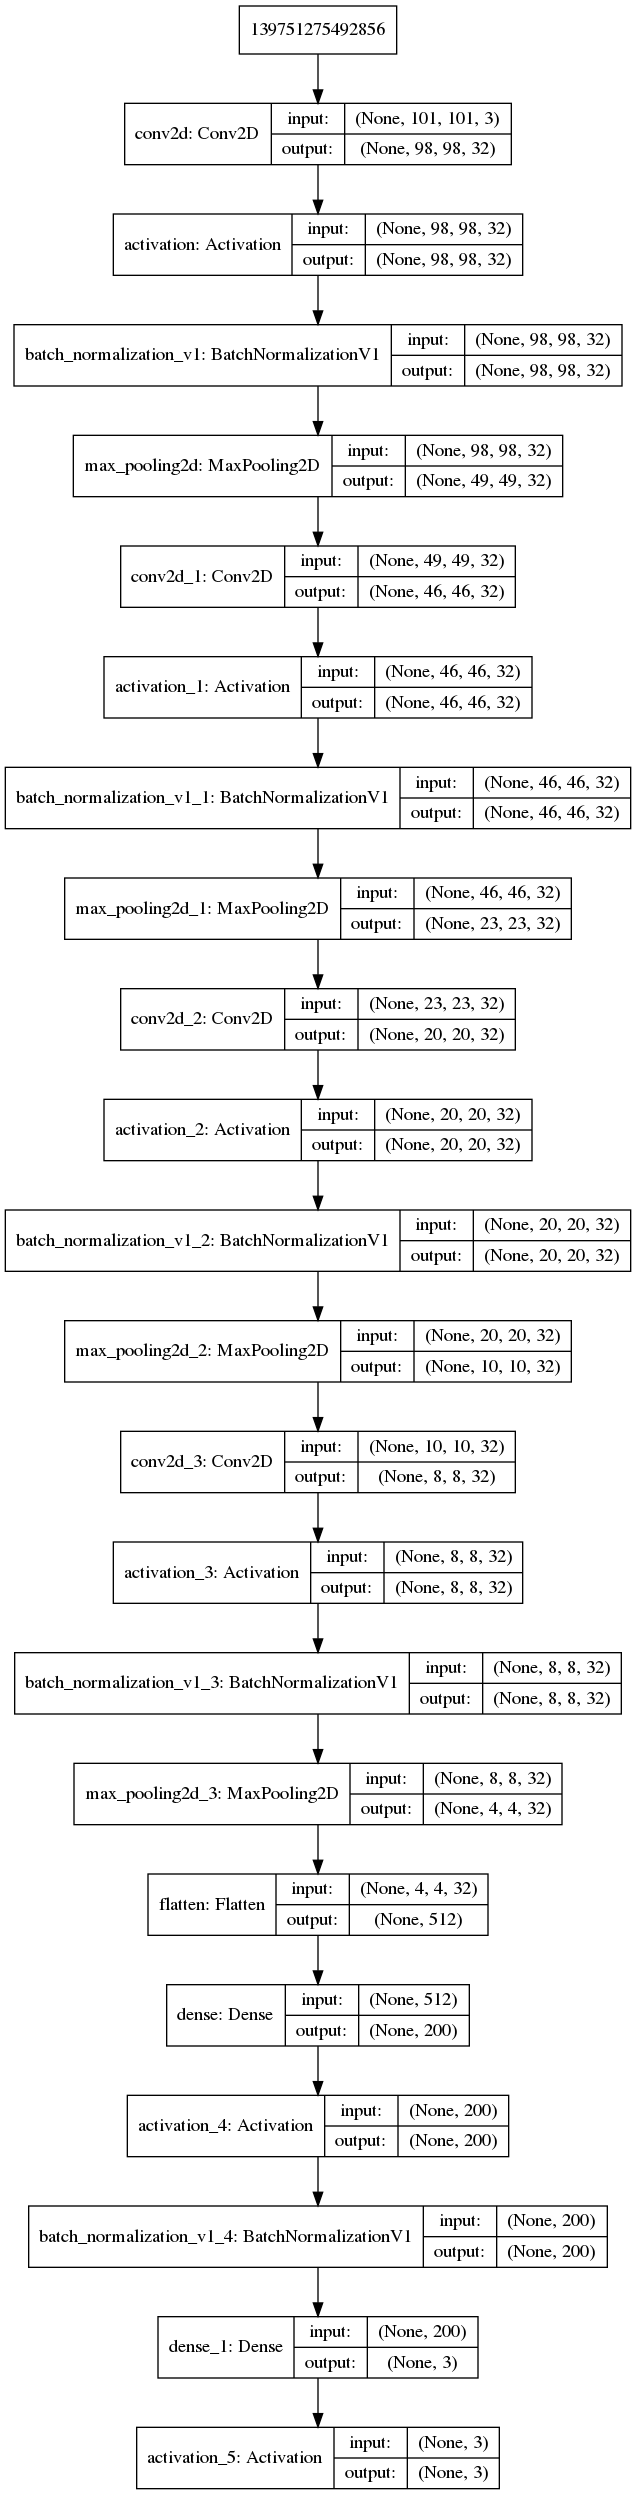

In [4]:
utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='plots/model.png')
Image(retina=True, filename='plots/model.png')

## Set up Training

Arguments for Training, that we need to set are:
* The path to the input dataset.
* The number of epochs to train for.
* Path for Our loss/accuracy plot, that will be output to disk

In [5]:
DATASET_PATH = os.getcwd() + "/dataset"
NUMBER_OF_EPOCHS = 100
BATCH_SIZE = 64
TRAIN_EVAL_PLOT_PATH = os.getcwd() + "/plots"

Here we can see the dataset structure:

+ dataset
    - left (X Files)
    - forward (X Files)
    - right (X Files)

Initialize the set of labels from dataset we are going to train our network on.

In [6]:
LABELS = set(["left", "forward", "right"])

Genrate a list of image pathes for our training

In [7]:
imagePaths = list(paths.list_images(DATASET_PATH))
print("Size of the training dataset: " + str(len(imagePaths)))

Size of the training dataset: 25870


Grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images

In [8]:
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
 
    if label not in LABELS:
        continue
 
    image = cv2.imread(imagePath)
    #image = imutils.resize(img, width=1280)
    image = cv2.resize(image, (101, 101))
 
    data.append(image)
    labels.append(label)

Convert the data into a NumPy array, then preprocess it by scaling all pixel intensities to the range (0, 1)

In [9]:
data = np.array(data, dtype="float") / 255.0

Creating one-hot encoding vectors on the labels, for example: <br>
(0,0,1) for "left" <br>
(0,1,0) for "forward" <br>
(1,0,0) for "right"

In [10]:
lb = LabelBinarizer()
hot_encoding_vectors = lb.fit_transform(labels)

Partition the data into training and testing splits using 70% of the data for training and the remaining 30% for testing

In [11]:
(trainX, testX, trainY, testY) = train_test_split(data,
                                                  hot_encoding_vectors,
                                                  test_size=0.3,
                                                  stratify=labels,
                                                  random_state=42)

Construct the training image generator for data augmentation

In [12]:
dataAugmentation = preprocessing.image.ImageDataGenerator(rotation_range=10,
                                                          zoom_range=0.15,
                                                          width_shift_range=0.2,
                                                          height_shift_range=0.2,
                                                          shear_range=0.15,
                                                          horizontal_flip=False,
                                                          vertical_flip=False,
                                                          fill_mode="nearest")

Initialize Adam Optimizer

In [13]:
adamOptimizer = optimizers.Adam(lr=1e-4, decay=1e-4 / NUMBER_OF_EPOCHS)

After the model is constructed, configure its learning process by calling the compile method

In [14]:
model.compile(loss="categorical_crossentropy", optimizer=adamOptimizer, metrics=["accuracy"])

## Training

Returns whether TensorFlow can access a Nvidia GPU with CUDA

In [15]:
tf.test.is_gpu_available(cuda_only=True)

True

Training the model on data generated batch-by-batch by a Python generator (or an instance of Sequence).
The generator is run in parallel to the model, for efficiency. For instance, this allows you to do real-time data augmentation on images on CPU in parallel to training your model on GPU.

In [16]:
start_time = time.time()

trainHistory = model.fit_generator(dataAugmentation.flow(trainX, trainY, batch_size=BATCH_SIZE),
                                   validation_data=(testX, testY),
                                   steps_per_epoch=len(trainX) // BATCH_SIZE,
                                   epochs=NUMBER_OF_EPOCHS,
                                   verbose=2)

end_time = time. time()
print("Total training time: " + str(end_time - start_time) + "[sec]")

Epoch 1/100
7761/7761 [==============================] - 3s 359us/sample - loss: 1.4778 - acc: 0.4296
 - 56s - loss: 0.8441 - acc: 0.6497 - val_loss: 1.4769 - val_acc: 0.4296
Epoch 2/100
7761/7761 [==============================] - 3s 366us/sample - loss: 0.5030 - acc: 0.8174
 - 47s - loss: 0.6128 - acc: 0.7642 - val_loss: 0.5029 - val_acc: 0.8174
Epoch 3/100
7761/7761 [==============================] - 3s 367us/sample - loss: 0.4869 - acc: 0.8204
 - 47s - loss: 0.5273 - acc: 0.8005 - val_loss: 0.4888 - val_acc: 0.8204
Epoch 4/100
7761/7761 [==============================] - 3s 339us/sample - loss: 0.4225 - acc: 0.8550
 - 46s - loss: 0.4796 - acc: 0.8232 - val_loss: 0.4238 - val_acc: 0.8550
Epoch 5/100
7761/7761 [==============================] - 3s 366us/sample - loss: 0.4197 - acc: 0.8459
 - 47s - loss: 0.4519 - acc: 0.8363 - val_loss: 0.4210 - val_acc: 0.8459
Epoch 6/100
7761/7761 [==============================] - 3s 364us/sample - loss: 0.4585 - acc: 0.8298
 - 47s - loss: 0.4263 -

7761/7761 [==============================] - 3s 368us/sample - loss: 0.4439 - acc: 0.8516
 - 47s - loss: 0.1956 - acc: 0.9446 - val_loss: 0.4445 - val_acc: 0.8516
Epoch 48/100
7761/7761 [==============================] - 3s 367us/sample - loss: 0.5512 - acc: 0.8183
 - 47s - loss: 0.2024 - acc: 0.9411 - val_loss: 0.5517 - val_acc: 0.8183
Epoch 49/100
7761/7761 [==============================] - 3s 364us/sample - loss: 0.2190 - acc: 0.9344
 - 47s - loss: 0.2004 - acc: 0.9404 - val_loss: 0.2199 - val_acc: 0.9344
Epoch 50/100
7761/7761 [==============================] - 3s 365us/sample - loss: 0.2979 - acc: 0.9048
 - 47s - loss: 0.1977 - acc: 0.9431 - val_loss: 0.2989 - val_acc: 0.9048
Epoch 51/100
7761/7761 [==============================] - 3s 366us/sample - loss: 0.4758 - acc: 0.8447
 - 47s - loss: 0.1935 - acc: 0.9448 - val_loss: 0.4754 - val_acc: 0.8447
Epoch 52/100
7761/7761 [==============================] - 3s 369us/sample - loss: 0.3180 - acc: 0.8938
 - 47s - loss: 0.1928 - acc: 0

Epoch 94/100
7761/7761 [==============================] - 3s 354us/sample - loss: 0.5541 - acc: 0.8467
 - 47s - loss: 0.1410 - acc: 0.9632 - val_loss: 0.5551 - val_acc: 0.8467
Epoch 95/100
7761/7761 [==============================] - 3s 361us/sample - loss: 0.3069 - acc: 0.9008
 - 48s - loss: 0.1434 - acc: 0.9624 - val_loss: 0.3089 - val_acc: 0.9008
Epoch 96/100
7761/7761 [==============================] - 3s 371us/sample - loss: 0.2238 - acc: 0.9357
 - 47s - loss: 0.1491 - acc: 0.9585 - val_loss: 0.2251 - val_acc: 0.9357
Epoch 97/100
7761/7761 [==============================] - 3s 366us/sample - loss: 0.6155 - acc: 0.8339
 - 47s - loss: 0.1396 - acc: 0.9629 - val_loss: 0.6205 - val_acc: 0.8339
Epoch 98/100
7761/7761 [==============================] - 3s 367us/sample - loss: 0.6282 - acc: 0.8262
 - 47s - loss: 0.1435 - acc: 0.9607 - val_loss: 0.6305 - val_acc: 0.8262
Epoch 99/100
7761/7761 [==============================] - 3s 362us/sample - loss: 0.3373 - acc: 0.8883
 - 46s - loss: 0.

A History.history attribute saves a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable).

## Evaluation
To evaluate our model, we’ll use the testX  data and print a classification_report

In [17]:
predictions = model.predict(testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=lb.classes_))

              precision    recall  f1-score   support

     forward       1.00      0.87      0.93      2618
        left       0.75      0.97      0.85      2323
       right       0.95      0.82      0.88      2820

   micro avg       0.89      0.89      0.89      7761
   macro avg       0.90      0.89      0.89      7761
weighted avg       0.91      0.89      0.89      7761



Plot our accuracy/loss training history and save it to disk

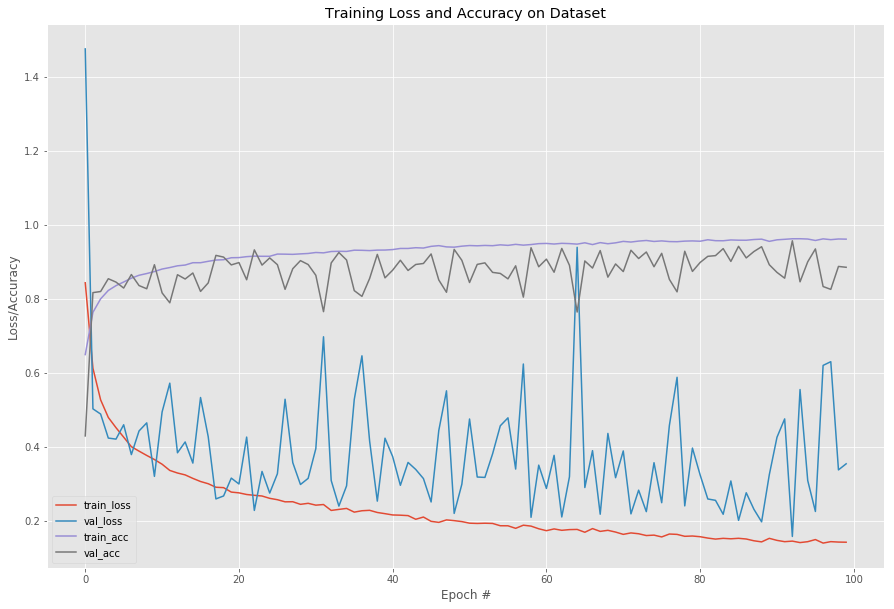

In [18]:
N = NUMBER_OF_EPOCHS
H = trainHistory
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(TRAIN_EVAL_PLOT_PATH + "/Loss_Accuracy.png")

## Saving model parameters

Save weights only (TensorFlow checkpoint file or Keras HDF5 format)

In [19]:
model.save_weights('./weights/weights.ckpt')
model.save_weights('./weights/weights.h5', save_format='h5')

Save configuration only (JSON or YAML format)

In [20]:
import json
import yaml

json_string = model.to_json()
yaml_string = model.to_yaml()

with open('./config/data.json', 'w') as outfile:
    json.dump(json_string, outfile)
    
with open('./config/data.yml', 'w') as outfile:
    yaml.dump(yaml_string, outfile)

Save entire model (HDF5 file)

In [21]:
model.save('./model/model.h5')

### Sources
- https://www.tensorflow.org/guide/keras
- http://rpg.ifi.uzh.ch/docs/RAL16_Giusti.pdf
- https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
- https://keras.io/models/sequential/